In [1]:
import os
import gc
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from  datetime import datetime, timedelta
import scipy as sp
%matplotlib inline


In [14]:
def single_autocorr(series, lag):
    """
    Autocorrelation for single data series
    :param series: traffic series
    :param lag: lag, days
    :return:
    """
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0


def batch_autocorr(data, lag, starts, ends, threshold, backoffset=0):
    """
    Calculate autocorrelation for batch (many time series at once)
    :param data: Time series, shape [n_pages, n_days]
    :param lag: Autocorrelation lag
    :param starts: Start index for each series
    :param ends: End index for each series
    :param threshold: Minimum support (ratio of time series length to lag) to calculate meaningful autocorrelation.
    :param backoffset: Offset from the series end, days.
    :return: autocorrelation, shape [n_series]. If series is too short (support less than threshold),
    autocorrelation value is NaN
    """
    n_series = data.shape[0]
    n_days = data.shape[1]
    max_end = n_days - backoffset
    corr = np.empty(n_series, dtype=np.float64)
    support = np.empty(n_series, dtype=np.float64)
    for i in range(n_series):
        series = data[i]
        end = min(ends[i], max_end)
        real_len = end - starts[i]
        support[i] = real_len/lag
        if support[i] > threshold:
            series = series[starts[i]:end]
            c_365 = single_autocorr(series, lag)
            c_364 = single_autocorr(series, lag-1)
            c_366 = single_autocorr(series, lag+1)
            # Average value between exact lag and two nearest neighborhs for smoothness
            corr[i] = 0.5 * c_365 + 0.25 * c_364 + 0.25 * c_366
        else:
            corr[i] = np.NaN
    return corr #, support


def find_start_end(data: np.ndarray):
    """
    Calculates start and end of real traffic data. Start is an index of first non-zero, non-NaN value,
     end is index of last non-zero, non-NaN value
    :param data: Time series, shape [n_pages, n_days]
    :return:
    """
    n_pages = data.shape[0]
    n_days = data.shape[1]
    start_idx = np.full(n_pages, -1, dtype=np.int32)
    end_idx = np.full(n_pages, -1, dtype=np.int32)
    for page in range(n_pages):
        # scan from start to the end
        for day in range(n_days):
            if not np.isnan(data[page, day]) and data[page, day] > 0:
                start_idx[page] = day
                break
        # reverse scan, from end to start
        for day in range(n_days - 1, -1, -1):
            if not np.isnan(data[page, day]) and data[page, day] > 0:
                end_idx[page] = day
                break
    return start_idx, end_idx

In [119]:
DIR = "../data"
N_ROWS = 1000
BATCH_SIZE = 32


LAGS = [365]
MAX_LAGS = max(LAGS)
DROP_BEFORE = 1

SEQ_LAST = False
ENC_LEN = 512
DEC_LEN = 28

VALID_LEN = 28
TEST_LEN = 28

TRAIN_LAST_DAY = 1913
USE_SERIES_LEN = TRAIN_LAST_DAY - DROP_BEFORE + 1 + 28

CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "int16", 'snap_TX': 'int16', 'snap_WI': 'int16' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

# FIRST_DAY = datetime(2011, 1, 29) 
# FORECAST_DAY = datetime(2016,4, 25) 

def load_data():
    label_encoders = {}
    
    prices = pd.read_csv(os.path.join(DIR, "sell_prices.csv"), dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(prices[col].astype(str).fillna("None"))
            prices[col] = label_encoders[col].transform(prices[col].astype(str).fillna("None")).astype("int16")
    
    cal = pd.read_csv(os.path.join(DIR, "calendar.csv"), dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(cal[col].astype(str).fillna("None"))
            cal[col] = label_encoders[col].transform(cal[col].astype(str).fillna("None")).astype("int16")
    
    numcols = [f"d_{day}" for day in range(DROP_BEFORE, TRAIN_LAST_DAY+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(os.path.join(DIR, "sales_train_validation.csv"), 
                     usecols = catcols + numcols, dtype = dtype, nrows=N_ROWS)
    
    for col in catcols:
        if col != "id":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(dt[col].astype(str).fillna("None"))
            dt[col] = label_encoders[col].transform(dt[col].astype(str).fillna("None")).astype("int16")

    for day in range(TRAIN_LAST_DAY+1, TRAIN_LAST_DAY+28+1):
        dt[f"d_{day}"] = np.nan
    
    product = dt[catcols].copy()
    print(f"product shape {product.shape}")

    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

    dt = dt.merge(cal[['d', 'wm_yr_wk']], on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    dt['d'] = dt['d'].str.replace('d_', '').astype("int32")
    price = dt.pivot(index="id", columns="d", values="sell_price")
    xy = dt.pivot(index="id", columns="d", values="sales")
    del dt; gc.collect()
    print(f"sale_xy shape {xy.shape}")
    print(f"price shape {price.shape}")

    cal_use_col = ['date', 'wday', 'month', 'year', 'event_name_1',
    'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
    'snap_WI']
    cal = cal[cal_use_col]
    cal['year'] = cal['year'] - cal['year'].min()
    cal['quarter'] = cal.date.dt.quarter
    cal = cal.drop("date", axis=1).T
    cal = cal[xy.columns]
    print(f"calendar shape {cal.shape}")
    
    submission = pd.read_csv(os.path.join(DIR, "sample_submission.csv"))
    print(f"submisson shape {submission.shape}")
    return xy, price, cal, product, submission

df_series, df_price, df_calendar, df_product, df_sub = load_data()

product shape (1000, 6)
sale_xy shape (1000, 1941)
price shape (1000, 1941)
calendar shape (11, 1941)
submisson shape (60980, 29)


In [226]:
starts, ends = find_start_end(df_series.values)

In [228]:
valid_lens = ends - starts

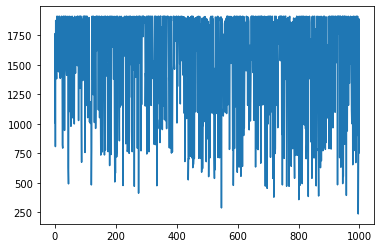

In [230]:
plt.plot(valid_lens)

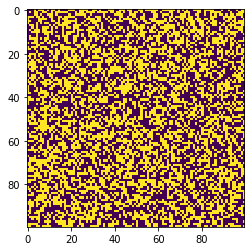

In [246]:
plt.imshow(np.random.randint(0, 2, [100, 100]))

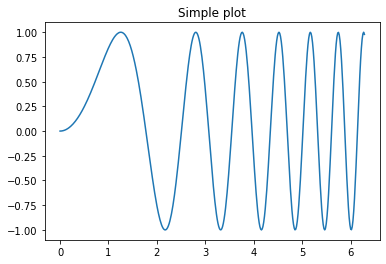

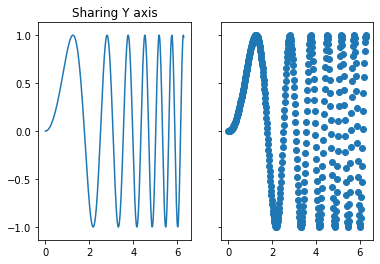

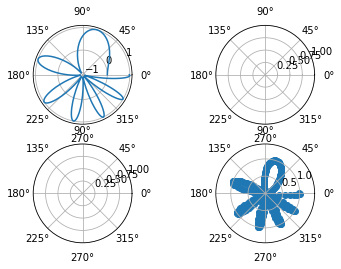

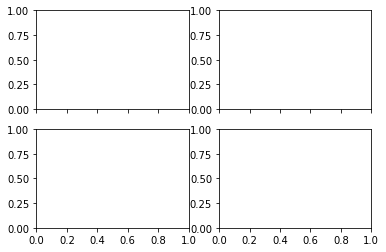

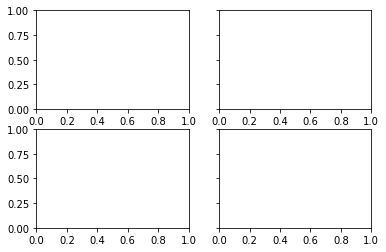

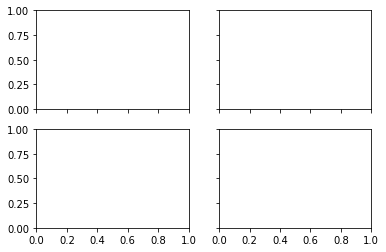

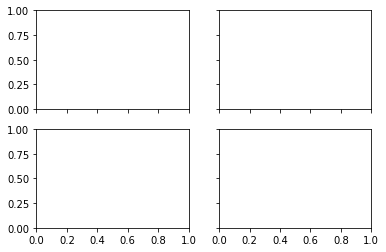

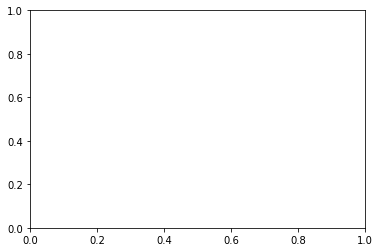

In [247]:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

# Create just a figure and only one subplot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(2, 2, subplot_kw=dict(polar=True))
axs[0, 0].plot(x, y)
axs[1, 1].scatter(x, y)

# Share a X axis with each column of subplots
plt.subplots(2, 2, sharex='col')

# Share a Y axis with each row of subplots
plt.subplots(2, 2, sharey='row')

# Share both X and Y axes with all subplots
plt.subplots(2, 2, sharex='all', sharey='all')

# Note that this is the same as
plt.subplots(2, 2, sharex=True, sharey=True)

# Create figure number 10 with a single subplot
# and clears it if it already exists.
fig, ax = plt.subplots(num=10, clear=True)

In [233]:
(valid_lens > 800).mean()

0.876

In [235]:
df_series

d,1,2,3,4,5,6,7,8,9,10,...,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_002_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_003_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_004_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_005_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_1_440_CA_1_validation,0.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUSEHOLD_1_441_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUSEHOLD_1_442_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [237]:
(ends < (1941 - DROP_BEFORE + 1)).mean()

1.0

In [221]:
df_series.iloc[:, -50].isnull().mean()

0.0

In [225]:
df_series.iloc[:, -50:-28].isnull().mean()

d
1892    0.0
1893    0.0
1894    0.0
1895    0.0
1896    0.0
1897    0.0
1898    0.0
1899    0.0
1900    0.0
1901    0.0
1902    0.0
1903    0.0
1904    0.0
1905    0.0
1906    0.0
1907    0.0
1908    0.0
1909    0.0
1910    0.0
1911    0.0
1912    0.0
1913    0.0
dtype: float64

In [240]:
ends.argpartition()

TypeError: Required argument 'kth' (pos 1) not found

In [120]:
data = df_series.iloc[:1000].values

In [121]:
starts, ends = find_start_end(data)

In [123]:
import tqdm

In [124]:
corr = []

for i in tqdm.tqdm(range(400)):
    corr.append(batch_autocorr(data, i, starts, ends, threshold=1.05))

  0%|                                                                                          | 0/400 [00:00<?, ?it/s]C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.23it/s]


In [126]:
corr = np.stack(corr, axis=1)

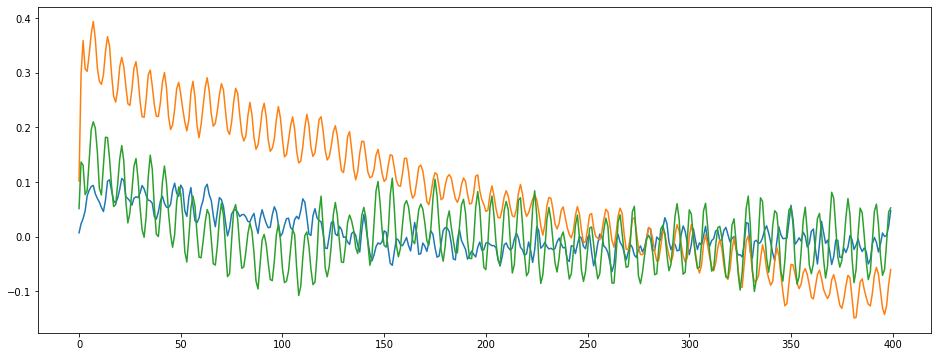

In [218]:
plt.figure(figsize=(16, 6))
for i in np.random.choice(range(1000), 3):
    plt.plot(corr[i])

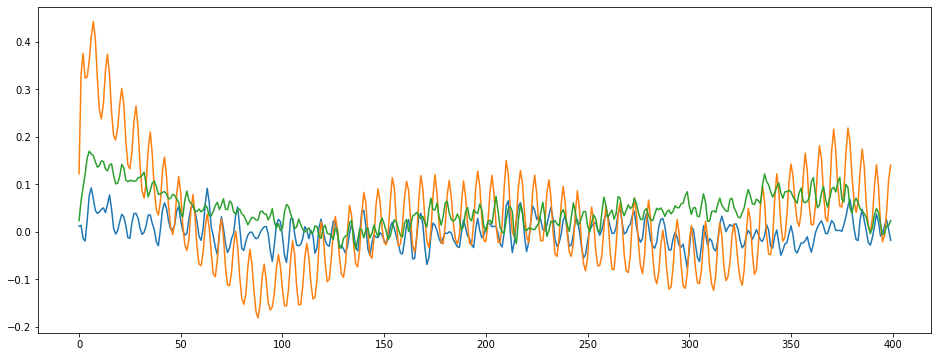

In [130]:
plt.figure(figsize=(16, 6))
for i in np.random.choice(range(1000), 3):
    plt.plot(corr[i])

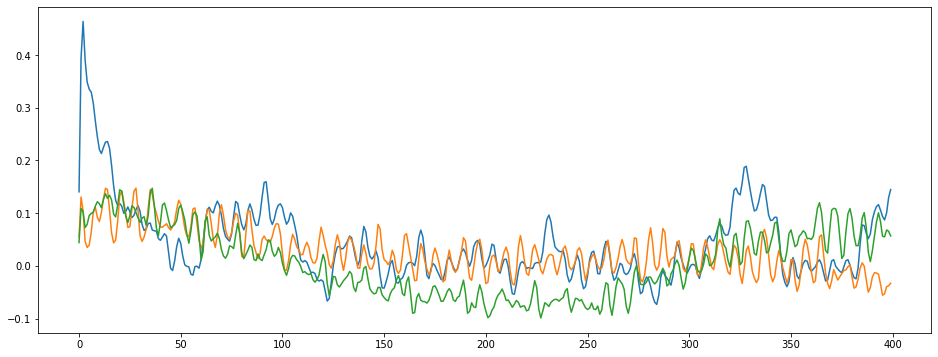

In [131]:
plt.figure(figsize=(16, 6))
for i in np.random.choice(range(1000), 3):
    plt.plot(corr[i])

In [174]:
np.argmin(corr,1)

(1000,)

365/90/120/150/180/240/270

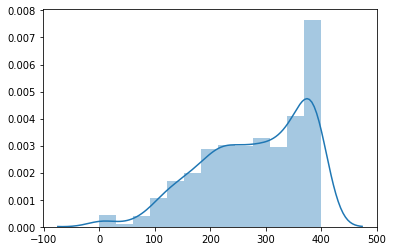

In [175]:
sns.distplot(np.argmin(corr,1) )

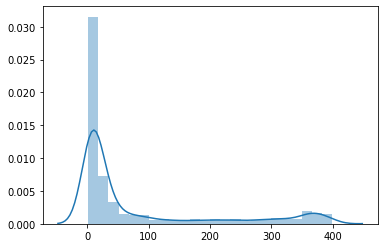

In [176]:
sns.distplot(np.argmax(corr,1) )

In [241]:
power = pd.read_csv('../data/df.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p).iloc[:, 10000:]

In [242]:
power

data_time,2018-06-20 16:00:00,2018-06-20 17:00:00,2018-06-20 18:00:00,2018-06-20 19:00:00,2018-06-20 20:00:00,2018-06-20 21:00:00,2018-06-20 22:00:00,2018-06-20 23:00:00,2018-06-21 00:00:00,2018-06-21 01:00:00,...,2020-04-15 14:00:00,2020-04-15 15:00:00,2020-04-15 16:00:00,2020-04-15 17:00:00,2020-04-15 18:00:00,2020-04-15 19:00:00,2020-04-15 20:00:00,2020-04-15 21:00:00,2020-04-15 22:00:00,2020-04-15 23:00:00
cid,,,,,,,,,,,,,,,,,,,,,
91E0B6DC00B41783E0530BC8100A0E30,10.267600,10.292658,10.134302,10.039225,9.995283,9.886318,9.011510,8.805857,8.688321,8.661651,...,9.656942,9.643891,9.650329,9.694016,9.631585,9.558167,9.479534,9.326953,8.629712,8.505145
91E0B6DC00B51783E0530BC8100A0E30,10.038972,10.078647,10.124974,10.158062,10.149430,9.875523,8.798581,8.384018,8.160186,8.067998,...,9.354836,9.331511,9.381401,9.448442,9.514657,9.566265,9.534905,9.418885,8.291041,7.909200
91E0B6DC00B91783E0530BC8100A0E30,9.769381,9.645101,9.568439,9.691338,9.595956,9.472823,9.454743,9.429662,9.442165,9.442153,...,9.930853,9.949363,9.728605,9.586129,9.539908,9.841113,9.958179,9.932017,9.902171,9.840213
91E0B6DC00BA1783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.379793,10.371832,10.354687,10.408397,10.402454,10.351226,10.370210,10.380129,10.355272,10.406317
91E0B6DC00BB1783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.521224,9.497918,9.521278,9.539263,9.578105,9.593460,9.548733,9.278921,8.203205,7.784954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91E0C8BAA1C5259EE0530BC8100AFFB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.125358,8.185542,8.277891,8.384448,8.457571,8.576566,8.546124,8.341388,8.069493,7.734396
91E0C8BAA1CB259EE0530BC8100AFFB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.375100,9.370061,9.292102,9.188006,9.164084,6.443777,6.306674,6.239941,6.203989,6.186016
91E1E413742C0582E0530BC8100A3E6E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.481430,8.343510,8.441935,8.352385,7.711793,7.623155,7.764489,7.604585,7.787220,8.488946


In [155]:
np.nan_to_num(corr_abs).sum(1).shape

(1000,)

In [154]:
corr_abs.shape

(1000, 400)

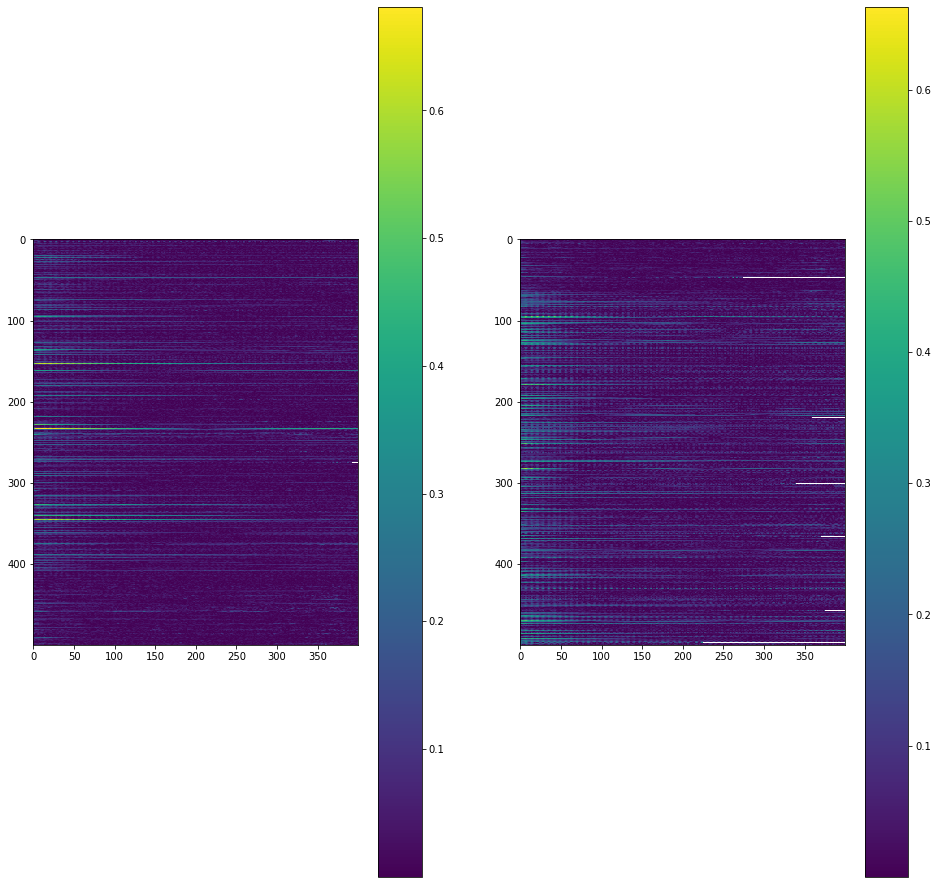

In [150]:
plt.figure(figsize=(16, 16))

plt.subplot(121)
plt.imshow(corr_abs[:500])
plt.colorbar()

plt.subplot(122)
plt.imshow(corr_abs[-500:])
plt.colorbar()

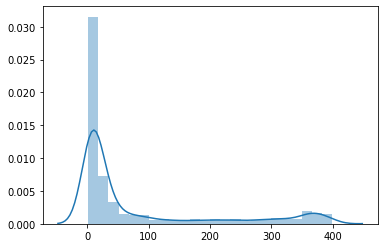

In [134]:
sns.distplot(np.argmax(corr,1) )

In [146]:
corr_abs = np.abs(corr)

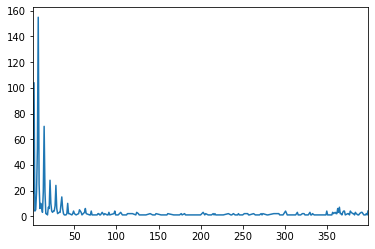

In [147]:
pd.Series(sorted(np.argmax(corr_abs,1))).value_counts().sort_index().plot()

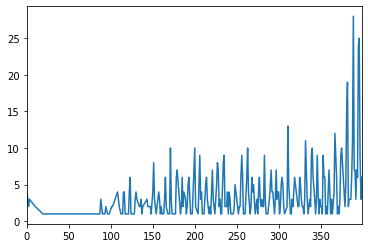

In [149]:
pd.Series(sorted(np.argmin(corr,1))).value_counts().sort_index().plot()

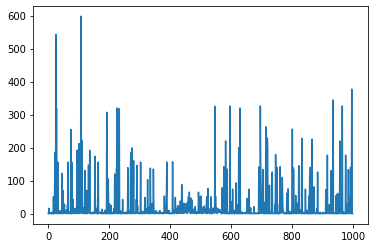

In [114]:
plt.plot(starts)

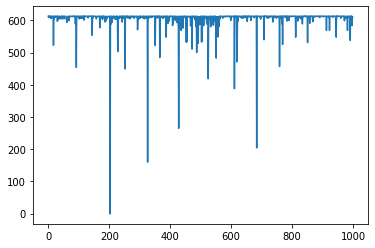

In [115]:
plt.plot(ends)

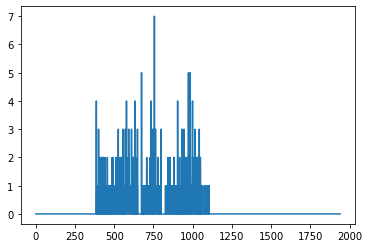

In [159]:
plt.plot(np.nan_to_num(data[np.argmin(ends)]))

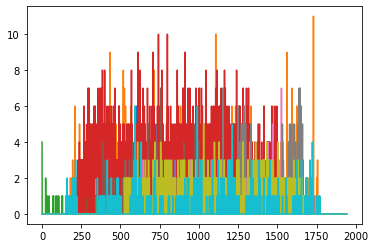

In [169]:
np.argpartition(ends, 10)

for i in np.argpartition(ends, 10)[:10]:
    plt.plot(np.nan_to_num(data[i]))